In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers, Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, Callback
import tifffile
from sklearn.metrics import classification_report, confusion_matrix
import json

In [2]:
%load_ext tensorboard

In [3]:
curr_dir = os.getcwd()
curr_dir

'C:\\Users\\kenny\\My Files\\NUS\\ISY5002 Pattern Recognition Systems\\04. PRS-PM Practice Module'

In [4]:
model_dir_name = f'{curr_dir}\\Code\\models\\fc16 CL_Fusion2'
log_dir_name = f'{curr_dir}\\Code\\logs\\fc16 CL_Fusion2'
output_dir_name = f'{curr_dir}\\Code\\output\\fc16 CL_Fusion2'

In [5]:
# base_dir_name = f'{curr_dir}\\Reduced Dataset'
base_dir_name = f'{curr_dir}\\DFC_Public_Dataset\\DFC_Public_Dataset'

all_files = os.listdir(base_dir_name)
season_dirs = [file_name for file_name in all_files if os.path.isdir(os.path.join(base_dir_name, file_name)) and file_name.startswith("ROIs0000")]

print(season_dirs)


['ROIs0000_autumn', 'ROIs0000_spring', 'ROIs0000_summer', 'ROIs0000_winter']


In [6]:
dfc_labels = []
s2_images = []

for season_dir in season_dirs:
    season_dir_path = '{}/{}'.format(base_dir_name, season_dir)
    sub_dirs = os.listdir(season_dir_path)
    sub_dirs = [sub_dir for sub_dir in sub_dirs if sub_dir.startswith("dfc") or sub_dir.startswith("s2")]
    for sub_dir in sub_dirs:
        sub_dir_path = "{}/{}".format(season_dir_path, sub_dir)
        files = os.listdir(sub_dir_path)
        files = ['{}/{}'.format(sub_dir_path, filename) for filename in files]
        if sub_dir.startswith("dfc"):
            dfc_labels.extend(files)
        else:
            s2_images.extend(files)

s2_images.sort()
dfc_labels.sort()



In [8]:
def pre_process_label(label):

    label[(label==4) | (label==6)] = 2 # shrubland, savanna, grassland, croplands
    label[label==5] = 3 # wetlands
    label[label==7] = 4 # urban
    label[label==9] = 5 # urban
    label[label==10] = 6
    return label

In [9]:
X_train, X_test, y_train, y_test = train_test_split(s2_images, dfc_labels, test_size=0.2, random_state=42)

In [10]:
INPUT_SHAPE = (256, 256, 8)
NUM_CLASSES = 7
MAX_VAL = 4096.0

# Augmentation Config
ROTATION_FACTOR = (-0.5, 0.5)
RAND_SEED = 42
SAMPLE_WEIGHT = [0., 1.1033, 1.0629, 1.1714, 1.1273, 1.2035, 1.0667]

# Training Config
BATCH_SIZE = 2
EPOCHS = 20
LEARNING_RATE = 1e-4
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
def compute_ndvi(image_array):
    # Assuming Red band is the first channel (0th index) and NIR is the second channel (1st index)
    red = image_array[:, :, 3]
    nir = image_array[:, :, 7]

    # Compute NDVI
    ndvi = (nir - red) / (nir + red + 1e-10)  # Small value added to the denominator to prevent division by zero

    return ndvi


In [12]:

def load_and_preprocess_image(img_path):
    #ds = gdal.Open(img_path)
    #img = ds.ReadAsArray()
    #img = np.moveaxis(img, 0, -1)
    if not isinstance(img_path, str):
        img_path = img_path.decode('utf-8')
    with tifffile.TiffFile(img_path) as tif:
        img = tif.asarray()
    band4 = img[:,:,3]
    band8 = img[:, :, 7]
    band11 = img[:, :, 11]
    band11 = tf.expand_dims(band11, axis=-1)  # Add a channel dimension to NDVI
    band4 = tf.expand_dims(band4, axis=-1) 
    band8 = tf.expand_dims(band8, axis=-1) 
    band11 = tf.clip_by_value(tf.cast(band11, tf.float32), 0., 1.)
    band4 = tf.clip_by_value(tf.cast(band4, tf.float32) / MAX_VAL, 0., 1.)
    band8 = tf.clip_by_value(tf.cast(band8, tf.float32) / MAX_VAL, 0., 1.)
    
    ndvi = compute_ndvi(img)
    ndvi = tf.expand_dims(ndvi, axis=-1)
    ndvi = (ndvi + 1.0) / 2.0
    ndvi = tf.clip_by_value(tf.cast(ndvi, tf.float32), 0., 1.)
    img = tf.clip_by_value(tf.cast(img, tf.float32) / MAX_VAL, 0., 1.)
    
    combined_img = tf.concat([img, ndvi], axis=-1)
    
    # Experiment with selected bands (comment out below 3 codes if plan to use full 14 channels)
    selected_bands = [1, 2, 3, 7, 4, 5, 6, 11]  # Adjusted for 0-based indexing
    selected_bands = tf.constant(selected_bands, dtype=tf.int32)  # Convert to a TensorFlow tensor
    combined_img = tf.gather(combined_img, selected_bands, axis=-1)
    
    return combined_img




def load_and_preprocess_label(label_path):
    #ds = gdal.Open(label_path)
    #label = ds.ReadAsArray()
    if not isinstance(label_path, str):
        label_path = label_path.decode('utf-8')
    with tifffile.TiffFile(label_path) as tif:
        label = tif.asarray()
    label = pre_process_label(label)
    label = label[:,:,np.newaxis]
    return label

In [13]:
# Define a generator function that yields batches of data
def data_generator(img_path_arr,label_path_arr):

    for (img_path,label_path) in zip(img_path_arr,label_path_arr):
        img = load_and_preprocess_image(img_path)
        label = load_and_preprocess_label(label_path)
        sample_weights = np.zeros_like(label, dtype=np.float32)
        for class_idx, weight in enumerate(SAMPLE_WEIGHT):
            sample_weights[label == class_idx] = weight

        yield img, label#, sample_weights


# Create a dataset from the generator function
ori_train_ds = tf.data.Dataset.from_generator(
    data_generator,
    args=(X_train, y_train),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 8), dtype=tf.float32),  # Example: Data tensor specification
        tf.TensorSpec(shape=(256,256,1), dtype=tf.uint8)
    )
)

# Create a dataset from the generator function
ori_eval_ds = tf.data.Dataset.from_generator(
    data_generator,
    args=(X_test, y_test),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 8), dtype=tf.float32),  # Example: Data tensor specification
        tf.TensorSpec(shape=(256,256,1), dtype=tf.uint8) # Example: Label tensor specification
    )
)

In [14]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [15]:
img_aug = Sequential([
        # layers.Resizing(height=self.img_size, width=self.img_size, interpolation='bicubic'),
        layers.experimental.preprocessing.RandomContrast(factor=(0.07, 0.1), seed=RAND_SEED),
        layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=RAND_SEED),
        layers.experimental.preprocessing.RandomFlip(mode='vertical', seed=RAND_SEED),
        layers.experimental.preprocessing.RandomRotation(ROTATION_FACTOR, fill_mode='reflect', interpolation='bilinear', seed=RAND_SEED),
        layers.experimental.preprocessing.RandomTranslation(height_factor=0.15, width_factor=0.15, fill_mode='reflect', interpolation='bilinear', seed=RAND_SEED)
    ])

label_aug = Sequential([
        # layers.Resizing(height=self.img_size, width=self.img_size, interpolation='nearest'),
        layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=RAND_SEED),
        layers.experimental.preprocessing.RandomFlip(mode='vertical', seed=RAND_SEED),
        layers.experimental.preprocessing.RandomRotation(ROTATION_FACTOR, fill_mode='reflect', interpolation='nearest', seed=RAND_SEED),
        layers.experimental.preprocessing.RandomTranslation(height_factor=0.15, width_factor=0.15, fill_mode='reflect', interpolation='nearest', seed=RAND_SEED)
    ])


In [16]:
#batched_train_ds = ori_train_ds.batch(BATCH_SIZE)
augmented_train_ds = (
    ori_train_ds.shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    # .map(img_aug, num_parallel_calls=AUTOTUNE)
    .map(lambda img, label: (img_aug(img), label_aug(label)), num_parallel_calls=AUTOTUNE)
    # .map(lambda img, label: (apply_blur(img), label), num_parallel_calls=AUTOTUNE)
    
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    ori_eval_ds
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)



C:\Users\kenny\anaconda3\envs\tfGPU\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [17]:
import numpy as np

def calculate_pixel_frequencies(dataset):
    # Initialize an array to store pixel frequencies for each class
    class_counts = np.zeros(7)  # Assuming classes are labeled from 0 to 6
    
    # Iterate over the dataset to count pixel frequencies
    for _, label in dataset:  # Assuming dataset yields (image, label) pairs
        unique, counts = np.unique(label, return_counts=True)
        for u, c in zip(unique, counts):
            class_counts[int(u)] += c

    return class_counts
def compute_class_weights(pixel_frequencies):
    # Compute class weights using the 'balanced' approach
    total_pixels = np.sum(pixel_frequencies)
    class_weights = total_pixels / (7 * pixel_frequencies)  # 7 classes

    return class_weights
# Calculate pixel frequencies from your dataset

gen_iter = iter(data_generator(s2_images, dfc_labels))
sample_img, sample_label = next(gen_iter)
print(sample_img.shape)


pixel_freqs = calculate_pixel_frequencies(ori_train_ds)

# Compute class weights
weights = compute_class_weights(pixel_freqs)


(256, 256, 8)


C:\Users\kenny\AppData\Local\Temp\ipykernel_3288\349571227.py:17: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_pixels / (7 * pixel_frequencies)  # 7 classes


In [18]:
if np.isinf(weights[0]):
    weights[0] = np.mean(weights[1:])

print(weights)

[1.9196781  0.61651863 0.41368626 3.13537743 1.42635145 5.35599681
 0.57013805]


In [19]:
import os

class PlotPredictions(Callback):
    def __init__(self, test_ds, num_samples=3, plot_every=5, save_path="."):
        super().__init__()
        self.test_ds = test_ds
        self.num_samples = num_samples
        self.plot_every = plot_every
        self.save_path = save_path
    
    

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.plot_every == 0:
            # Randomly select samples
            samples = np.random.choice(len(X_test), self.num_samples, replace=False)

            fig, ax = plt.subplots(self.num_samples, 2, figsize=(10, 5 * self.num_samples))

            for i, sample_index in enumerate(samples):
                img, actual_label = next(iter(self.test_ds.skip(sample_index).take(1)))
                img = tf.reshape(img, [1, 256, 256, 8])
                
                first_4_channels = img[:, :, :, :4]  # Shape: (1, 256, 256, 4)
                last_4_channels = img[:, :, :, 4:]  # Shape: (1, 256, 256, 4)

                predicted_label = np.argmax(model.predict(first_4_channels,last_4_channels), axis=-1)

                predicted_label = predicted_label.reshape((predicted_label.shape[1], predicted_label.shape[2]))
                # Plot actual label

                actual_label = tf.reshape(actual_label, [actual_label.shape[0], actual_label.shape[1]])
                actual_label = actual_label.numpy()

                ax[i, 0].imshow(actual_label, cmap='tab10', vmin=0, vmax=5)
                ax[i, 0].set_title(f"Actual Label {i+1}")

                ax[i, 1].imshow(predicted_label, cmap='tab10', vmin=0, vmax=5)
                ax[i, 1].set_title(f"Predicted Label {i+1}")

            plt.tight_layout()

            # Save the combined plot
            file_name = f"{self.save_path}/FCN16CLFusion2_test_{epoch}.png"
            save_location = os.path.join(self.save_path, file_name)
            plt.savefig(save_location)
            plt.close()

# Usage



In [20]:
class ClassificationReportCallback(Callback):
    def __init__(self, dataset, steps, filepath="class_report_FCN16CLFusion2.json", matrix_path="confusion_matrix_FCN16CLFusion2.png"):
        super(ClassificationReportCallback, self).__init__()
        self.dataset = dataset
        self.steps = steps
        self.filepath = filepath
        self.matrix_path = matrix_path
        self.reports = []

    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(self.matrix_path)
        plt.close()

    def on_epoch_end(self, epoch, logs=None):
        if(epoch + 1) % 5 == 0:
            y_true = []
            y_pred_list = []

            # Iterate over the dataset to get predictions and true labels
            for step, (x_batch, y_batch) in enumerate(self.dataset.take(self.steps)):
                y_true.extend(y_batch.numpy().reshape(-1))
                y_pred_probs = model.predict(x_batch)
                y_pred = np.argmax(y_pred_probs, axis=-1).reshape(-1)
                y_pred_list.extend(y_pred)

            y_true = np.array(y_true)
            y_pred_list = np.array(y_pred_list)

            # Compute classification report
            report = classification_report(y_true, y_pred_list, output_dict=True)

            # Compute per-class accuracy
            accuracy_per_class = {}
            for i in range(len(np.unique(y_true))):
                correct = np.sum((y_true == i) & (y_pred_list == i))
                total = np.sum(y_true == i)
                accuracy = correct / total
                accuracy_per_class[f"class_{i}"] = accuracy

            # Compute confusion matrix
            cm = confusion_matrix(y_true, y_pred_list)
            self.plot_confusion_matrix(cm, classes=np.unique(y_true), title='Confusion Matrix')

            # Debug output for file paths
            print("JSON File Path:", self.filepath)
            print("PNG File Path:", self.matrix_path)
            
            # Append to reports
            self.reports.append({
                "epoch": epoch,
                "classification_report": report,
                "accuracy_per_class": accuracy_per_class
            })

            # Save to JSON file
            with open(self.filepath, 'w') as f:
                json.dump(self.reports, f)

In [21]:
from tensorflow.keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    """
    weights = tf.constant(weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        #y_true = tf.cast(y_true, tf.float32)
        
        y_true = tf.one_hot(tf.cast(tf.squeeze(y_true, axis=-1), tf.int32), depth=7)
        class_loglosses = K.mean(K.categorical_crossentropy(y_true, y_pred, from_logits=False), axis=[0, 1, 2])
        return K.sum(class_loglosses * K.constant(weights))


    return loss


In [23]:
plot_predictions_cb = PlotPredictions(ori_eval_ds, save_path=output_dir_name)

In [24]:
tensorboard_callback = TensorBoard(log_dir=log_dir_name, histogram_freq=1, update_freq=5)


In [25]:
model_file_name = f"{model_dir_name}/model_FCN16_CLFusion2.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_file_name,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [26]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [27]:
loss_function = weighted_categorical_crossentropy(weights)


In [29]:
import keras
from keras.layers import Conv2D, Dropout, Input, MaxPooling2D, Conv2DTranspose, Add, Softmax
from keras.layers.core import Activation
from keras.layers.convolutional import Cropping2D
from keras.models import Model
from keras.utils import plot_model
from filter import bilinear

def Fusion_model(n_classes = NUM_CLASSES, shape  = INPUT_SHAPE):

    Lin = Input(shape=(256,256,4))
        
    Lx = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_convL1' )(Lin)
    Lx = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_convL2' )(Lx)
    Lx = MaxPooling2D((2, 2), strides=(2, 2), name='blockL1_pool' )(Lx)
    f1 = Lx
    # Block 2
    Lx = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_convL1' )(Lx)
    Lx = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_convL2' )(Lx)
    Lx = MaxPooling2D((2, 2), strides=(2, 2), name='blockL2_pool' )(Lx)
    f2 = Lx

    # Block 3
    Lx = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_convL1' )(Lx)
    Lx = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_convL2' )(Lx)
    Lx = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_convL3' )(Lx)
    Lx = MaxPooling2D((2, 2), strides=(2, 2), name='blockL3_pool' )(Lx)
    f3 = Lx

    # Block 4
    Lx = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_convL1' )(Lx)
    Lx = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_convL2' )(Lx)
    Lx = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_convL3' )(Lx)
    Lx = MaxPooling2D((2, 2), strides=(2, 2), name='blockL4_pool' )(Lx)
    f4 = Lx

    # Block 5
    Lx = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_convL1' )(Lx)
    Lx = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_convL2' )(Lx)
    Lx = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_convL3' )(Lx)
    Lx = MaxPooling2D((2, 2), strides=(2, 2), name='blockL5_pool' )(Lx)
    f5 = Lx
  
    Lx = f5
    Lx = Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same' )(Lx)
    Lx = Dropout(0.5)(Lx)
    Lx = Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same' )(Lx)
    Lx = Dropout(0.5)(Lx)

    Lx = Conv2D( n_classes ,  ( 1 , 1 ) ,activation = 'relu' )(Lx)
    Lx = Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False, kernel_initializer=bilinear )(Lx)
    Lx = Cropping2D(((1, 1), (1, 1)))(Lx)

    Lx2 = f4
    Lx2 = Conv2D( n_classes ,  ( 1 , 1 ) ,activation = 'relu')(Lx2)

    Lx = Add()([ Lx , Lx2 ])

    Lx = Conv2DTranspose( n_classes , kernel_size=(32,32) ,  strides=(16,16) , use_bias=False )(Lx)
    Lx = Cropping2D(((8, 8), (8, 8)))(Lx)

     
    Rin = Input(shape=(256,256,4))
        
    Rx = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_convR1' )(Rin)
    Rx = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_convR2' )(Rx)
    Rx = MaxPooling2D((2, 2), strides=(2, 2), name='blockR1_pool' )(Rx)
    g1 = Rx
    # Block 2
    Rx = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_convR1' )(Rx)
    Rx = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_convR2' )(Rx)
    Rx = MaxPooling2D((2, 2), strides=(2, 2), name='blockR2_pool' )(Rx)
    g2 = Rx

    # Block 3
    Rx = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_convR1' )(Rx)
    Rx = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_convR2' )(Rx)
    Rx = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_convR3' )(Rx)
    Rx = MaxPooling2D((2, 2), strides=(2, 2), name='blockR3_pool' )(Rx)
    g3 = Rx

    # Block 4
    Rx = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_convR1' )(Rx)
    Rx = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_convR2' )(Rx)
    Rx = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_convR3' )(Rx)
    Rx = MaxPooling2D((2, 2), strides=(2, 2), name='blockR4_pool' )(Rx)
    g4 = Rx

    # Block 5
    Rx = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_convR1' )(Rx)
    Rx = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_convR2' )(Rx)
    Rx = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_convR3' )(Rx)
    Rx = MaxPooling2D((2, 2), strides=(2, 2), name='blockR5_pool' )(Rx)
    g5 = Rx
  
    Rx = g5
    Rx = Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same' )(Rx)
    Rx = Dropout(0.5)(Rx)
    Rx = Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same' )(Rx)
    Rx = Dropout(0.5)(Rx)

    Rx = Conv2D( n_classes ,  ( 1 , 1 ) ,activation = 'relu' )(Rx)
    Rx = Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False, kernel_initializer=bilinear )(Rx)
    Rx = Cropping2D(((1, 1), (1, 1)))(Rx)

    Rx2 = g4
    Rx2 = Conv2D( n_classes ,  ( 1 , 1 ) ,activation = 'relu')(Rx2)

    Rx = Add()([ Rx , Rx2 ])

    Rx = Conv2DTranspose( n_classes , kernel_size=(32,32) ,  strides=(16,16) , use_bias=False )(Rx)
    Rx = Cropping2D(((8, 8), (8, 8)))(Rx)
    
    o = Add()([ Lx , Rx ])
    o = Softmax(axis=3)(o)
    
    model = Model(inputs=[Lin,Rin], outputs=o)

    return model


In [30]:
# from fcn16_Fusion2 import *

# fcn16_fusion_model = fcn16_fusion(n_classes = NUM_CLASSES, shape  = INPUT_SHAPE)
model = Fusion_model(n_classes = NUM_CLASSES, shape  = INPUT_SHAPE)

# visualize(model, 'model.jpg')

model.compile(tf.keras.optimizers.Adam(LEARNING_RATE), loss=loss_function, metrics=['accuracy'])

In [31]:
def plot_history(history, epoch_count, filename):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss at Epoch {epoch_count}')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy at Epoch {epoch_count}')
    plt.legend()

    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

In [32]:
model.load_weights(f"{model_dir_name}/model_FCN16_CLFusion2.h5")

In [33]:
def split_channels(image, label):
    first_4_channels = image[:, :, :, :4]
    last_4_channels = image[:, :, :, 4:]
    return (first_4_channels, last_4_channels), label


In [34]:
# epochs_list = [10, 20, 30, 40, 50]
epochs_list = [10]

# Assuming you have already defined your model, training_data, and validation_data
for epochs in epochs_list:
    # If not the first stage, load weights from the previous stage
    if epochs != epochs_list[0]:
        model.load_weights(f"{model_dir_name}/model_FCN16_CLFusion2.h5")

    # Train the model
    classification_rep_filename = f'{output_dir_name}/classication_report16F2_{epochs}.json'
    confusion_matrix_filename = f'{output_dir_name}/confusion_matrix16F2_{epochs}.png'
    
    classification_rep_callback = ClassificationReportCallback(val_ds, len(X_test), classification_rep_filename,
                                                              confusion_matrix_filename)
#     history = model.fit(
#         augmented_train_ds,
#         validation_data=val_ds,
#         epochs=epochs,
# #         callbacks=[early_stopping_callback, model_checkpoint_callback, plot_predictions_cb, tensorboard_callback,
# #                   classification_rep_callback],
#         callbacks=[early_stopping_callback, model_checkpoint_callback, plot_predictions_cb, tensorboard_callback],
#         initial_epoch=epochs - 10  # Start from the last epoch
#     )

    augmented_train_ds_split = augmented_train_ds.map(split_channels)
    val_ds_split = val_ds.map(split_channels)

    history = model.fit(
        augmented_train_ds_split,
        validation_data=val_ds_split,
        epochs=epochs,
        callbacks=[early_stopping_callback, model_checkpoint_callback, tensorboard_callback],
        initial_epoch=epochs - 10
    )
    
    # Plot and save the history
    filename = f"{output_dir_name}/plots_FCN16CLFusion2_epoch_{epochs}.png"
    plot_history(history, epochs, filename)

Epoch 1/10
   2446/Unknown - 987s 397ms/step - loss: 9.5054 - accuracy: 0.7347
Epoch 1: val_loss improved from inf to 8.72336, saving model to C:\Users\kenny\My Files\NUS\ISY5002 Pattern Recognition Systems\04. PRS-PM Practice Module\Code\models\fc16 CL_Fusion2\model_FCN16_CLFusion2.h5
2446/2446 [==============================] - 1350s 545ms/step - loss: 9.5054 - accuracy: 0.7347 - val_loss: 8.7234 - val_accuracy: 0.7587
Epoch 2/10
2446/2446 [==============================] - ETA: 0s - loss: 9.4540 - accuracy: 0.7383
Epoch 2: val_loss improved from 8.72336 to 8.61685, saving model to C:\Users\kenny\My Files\NUS\ISY5002 Pattern Recognition Systems\04. PRS-PM Practice Module\Code\models\fc16 CL_Fusion2\model_FCN16_CLFusion2.h5
2446/2446 [==============================] - 1319s 539ms/step - loss: 9.4540 - accuracy: 0.7383 - val_loss: 8.6168 - val_accuracy: 0.7624
Epoch 3/10
2446/2446 [==============================] - ETA: 0s - loss: 9.4046 - accuracy: 0.7393
Epoch 3: val_loss improved fr

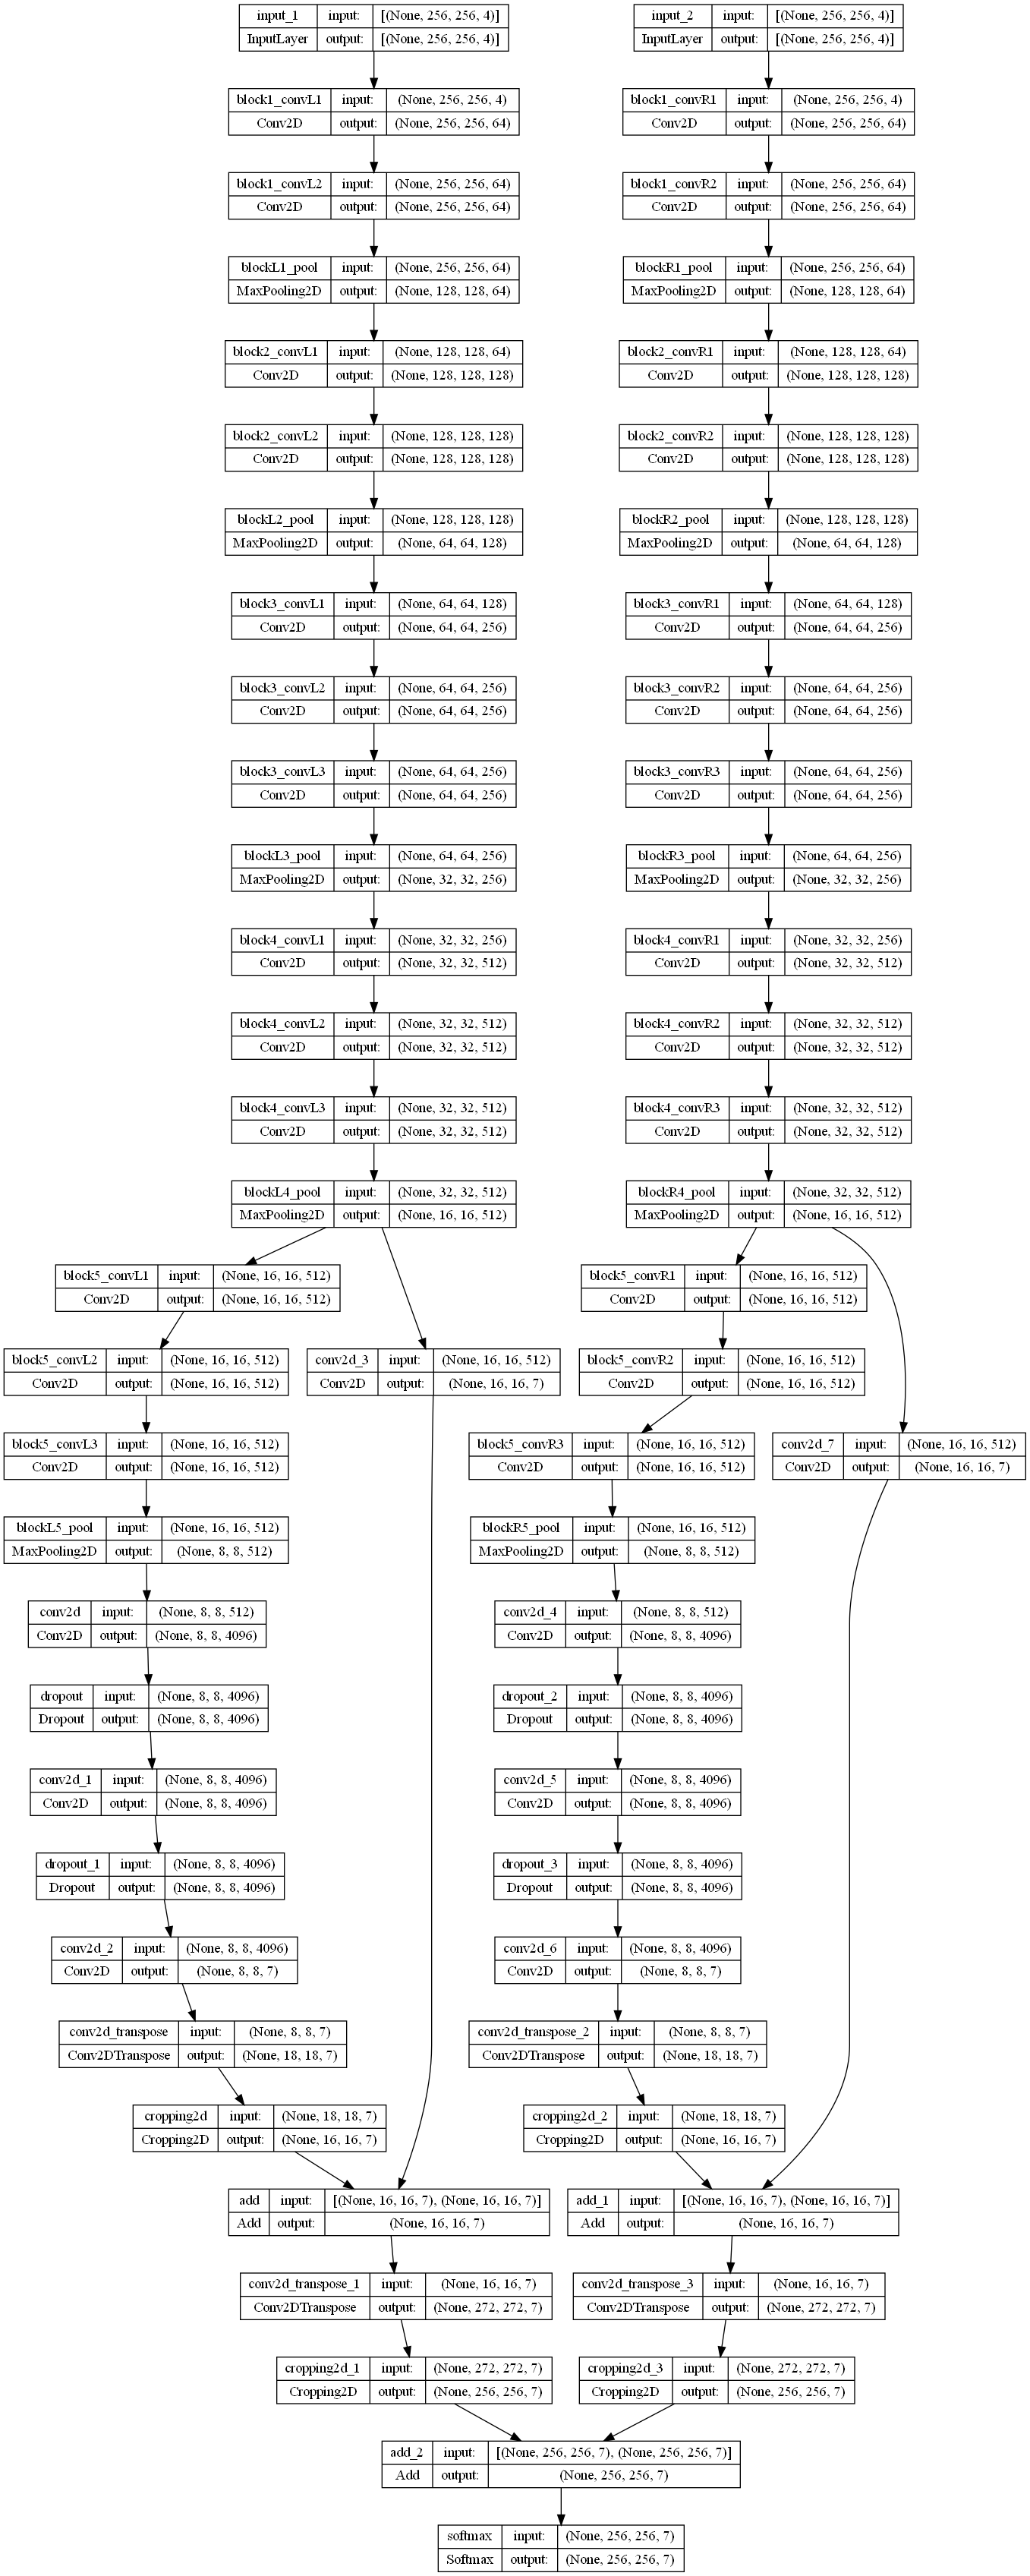

In [36]:
# from tensorflow.keras.utils import plot_model

plot_model(model, to_file='FCN16_Fusion2.png', show_shapes=True, rankdir='TB')